# Modeling

Train/Test Split

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

df = pd.read_csv("/content/Telco-Chrun-Cleaned.csv")

# Convert 'TotalCharges' to numeric, coercing errors and filling NaNs with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [27]:
df["charges_per_tenure"] = df["MonthlyCharges"] / (df["tenure"] + 1)
df["tenure_bucket"] = pd.cut(
    df["tenure"],
    bins=[0, 6, 12, 24, 60, 100],
    labels=["0-6", "6-12", "12-24", "24-60", "60+"]
)

In [28]:
num_features = ["tenure", "MonthlyCharges", "TotalCharges", "charges_per_tenure"]
cat_features = [c for c in X_train.columns if X_train[c].dtype == "object"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler())]), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
    ],
    remainder="drop",
)

In [29]:
X = df.drop(columns=["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

Logistic Regression Baseline

In [30]:
model = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=5000))
])

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)

np.float64(0.8455087964039371)

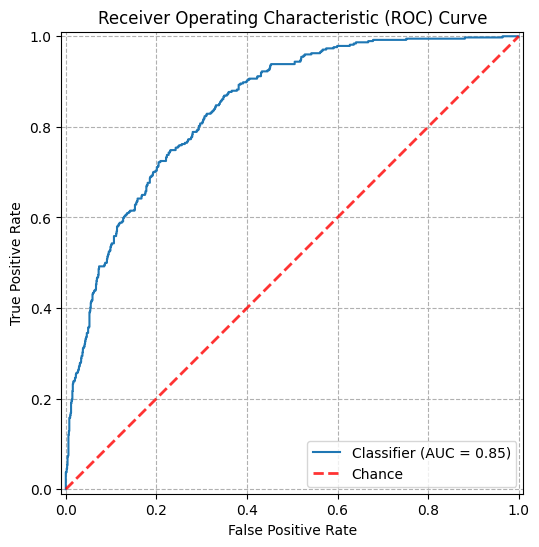

In [32]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_proba are already defined from the previous cell

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc="lower right")
plt.grid(linestyle='--')
plt.show()

In [31]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])

rf.fit(X_train, y_train)
roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])


np.float64(0.8299271487251026)

In [34]:
from sklearn.metrics import confusion_matrix

def evaluate_threshold(y_true, y_prob, threshold):
    preds = (y_prob >= threshold).astype(int)
    return confusion_matrix(y_true, preds)

for t in [0.3, 0.5, 0.7]:
    print(f"Threshold {t}")
    print(evaluate_threshold(y_test, y_pred_proba, t))

Threshold 0.3
[[789 246]
 [ 94 280]]
Threshold 0.5
[[935 100]
 [178 196]]
Threshold 0.7
[[1016   19]
 [ 285   89]]


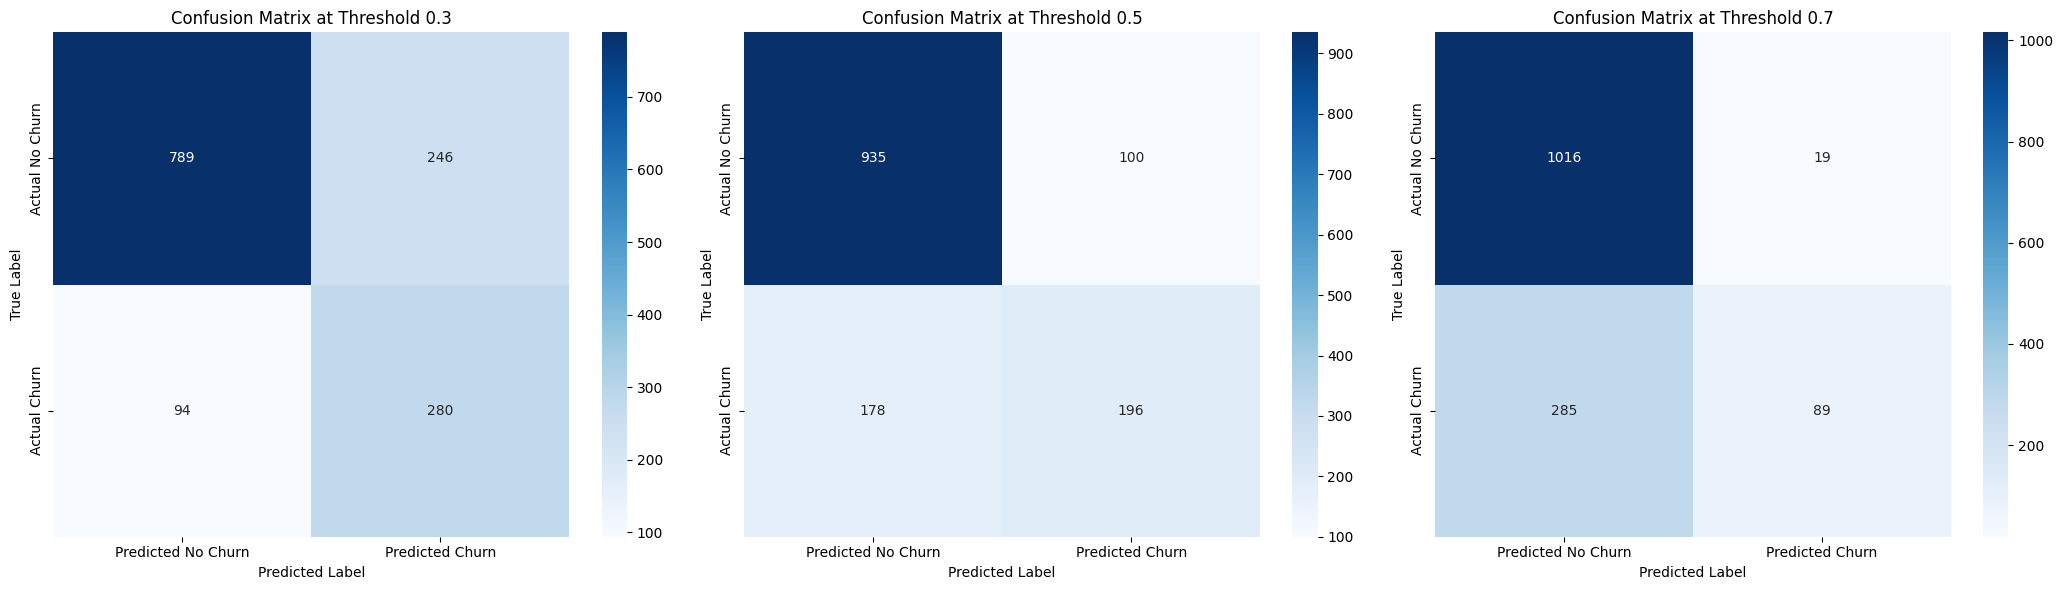

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_prob, threshold, ax):
    preds = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted No Churn', 'Predicted Churn'],
                yticklabels=['Actual No Churn', 'Actual Churn'])
    ax.set_title(f'Confusion Matrix at Threshold {threshold}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

for i, t in enumerate([0.3, 0.5, 0.7]):
    plot_confusion_matrix(y_test, y_pred_proba, t, axes[i])

plt.tight_layout()
plt.show()

Lower thresholds increase recall (catching more churners) but at the cost of targeting more customers.
Higher thresholds reduce incentive spend but risk missing at-risk customers.
